In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf

In [2]:
from keras_vggface.vggface import VGGFace
model = VGGFace(model='vgg16')

In [3]:
model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

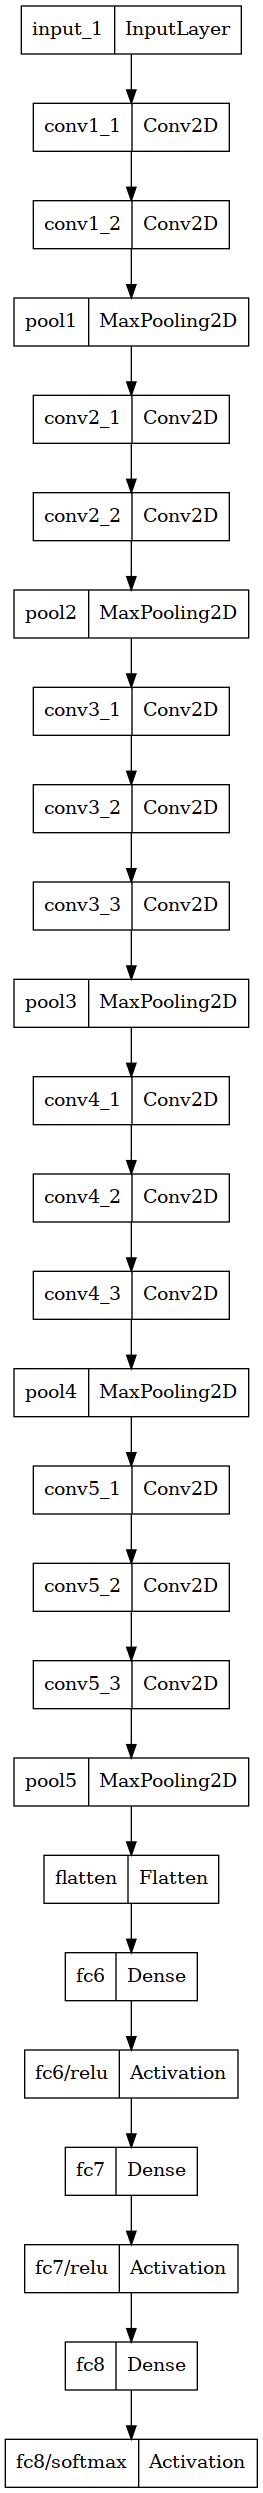

In [4]:
from tensorflow.keras.utils import plot_model

# plot model and display image
plot_model(model, to_file='model.png')

In [5]:
# iterate over the layers and export models from first to current layer to h5 files
for i in range(0, len(model.layers)):
    model_i = tf.keras.Model(inputs=model.inputs, outputs=model.layers[i].output, name=f"model_{i}")
    model_i.save(f"model_{i}/model.h5")
    # print(model_i.summary())

/home/cathie/miniconda3/envs/oppai/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
import tf2onnx

spec = tf.TensorSpec([1, 224, 224, 3], tf.float32, name="input_0")

for i in range(1, len(model.layers)):
    model_i = tf.keras.models.load_model(f'model_{i}/model.h5')
    tf2onnx.convert.from_keras(
        model_i,
        input_signature=[spec],
        inputs_as_nchw=['input_0'],
        opset=12,
        output_path=f'model_{i}/model.onnx'
    )
    tf2onnx.convert.from_keras(
        model_i,
        input_signature=[spec],
        inputs_as_nchw=['input_0'],
        opset=18,
        output_path=f'model_{i}/opset18.onnx'
    )

In [7]:
# Ref: https://github.com/zkonduit/ezkl/blob/bceac2fab530fd01701aec3d8018ce318f6c42e1/examples/notebooks/mnist_vae.ipynb
!RUST_LOG=trace

# import os
import ezkl
import json


for i in range(1, len(model.layers)):
    model_path = os.path.join(f'model_{i}/model.onnx')
    settings_path = os.path.join(f'model_{i}/settings.json')

    res = ezkl.gen_settings(model_path, settings_path)
    assert res == True

    # read the settings from json
    with open(settings_path, 'r') as f:
        settings = json.load(f)
    
    # print the "num_rows" from the settings
    print(settings['num_rows'])

56061795
986655450
994282259
1456838829
2376332298
2380145667
2834436468
3740208268
4645979947
4647886682
5090448494
5974167244
6857885885
6858839141
7070036711
7281234262
7492431870
7492670126


: 